# Data Structures in cluster_generator

---

In the Quickguides, we've shown off a lot of the bells and whistles of ``cluster_generator``, but for a more in-depth user, more detail may be required. This guide will discuss the core data structures in the ``cluster_generator`` package and how to interact with them.

## Contents
- [Data Structures](#Data-Structures)
  - [RadialProfiles](#Radial-Profiles)
    - [Accessing / Using Existing Profiles](#Accessing-and-Using-Existing-Profiles)
    - [Creating Profiles](#Creating-Profiles)
    - [IO Operations](#I/O-Operations-on-RadialProfiles)
  - [Potential](#Potentials)
    - [Modified Gravity?](#Alternative-Gravity-Theories)
  - [ClusterModel](#ClusterModel)
  - [ClusterParticles](#ClusterParticles)
  - [ClusterICs](#ClusterICs)

---

## Data Structures
The ``cluster_generator`` package comes with a lot of different classes which can be a bit confusing to manage. In this guide, we are going to go through the 5 major classes in the package and describe their usage in most cases. For more concrete details on all of the classes discussed, check out the API documentation.

### Radial Profiles
Radial profiles are the underlying equations describing measurable quantities like density, entropy, temperature, etc. There are a wide array of available ``RadialProfile`` objects built into the ``cluster_generator`` software, and it is easy to set up custom ones.

#### Accessing and Using Existing Profiles

In [10]:
import cluster_generator as cg
import numpy as np
import matplotlib.pyplot as plt
# Look at the built-in options #
print(f"There are {len(cg.radial_profiles.RadialProfile.builtin)} profiles built in: {cg.radial_profiles.RadialProfile.builtin}.")

There are 25 profiles built in: ['constant_profile', 'power_law_profile', 'beta_model_profile', 'hernquist_density_profile', 'cored_hernquist_density_profile', 'hernquist_mass_profile', 'nfw_density_profile', 'nfw_mass_profile', 'tnfw_density_profile', 'tnfw_mass_profile', 'snfw_density_profile', 'snfw_mass_profile', 'cored_snfw_density_profile', 'cored_snfw_mass_profile', 'cored_snfw_total_mass', 'einasto_density_profile', 'einasto_mass_profile', 'am06_density_profile', 'vikhlinin_density_profile', 'vikhlinin_temperature_profile', 'am06_temperature_profile', 'baseline_entropy_profile', 'broken_entropy_profile', 'walker_entropy_profile', 'rescale_profile_by_mass'].


You can create any one of these profiles by one of two methods:

In [11]:
# -- direct calling -- #
profile_example = cg.radial_profiles.nfw_density_profile(1e7,1000)
other_profile_example = cg.radial_profiles.RadialProfile.built_in("nfw_density_profile",1e7,1000)

print(profile_example,other_profile_example)

RadialProfile; type=nfw_density_profile. RadialProfile; type=nfw_density_profile.


``RadialProfile`` objects are just wrappers for standard functions with some additional functionality. You can operate on them just as you would any other objects, and the functions will automatically be summed behind the scenes. The base function is stored in the ``RadialProfile.profile`` attribute, and can be accessed directly if necessary.

The ``RadialProfile`` object has a few additional methods that are useful. You can add a core or truncate a profile with ``.add_core`` and ``.cutoff`` respectively. For example,

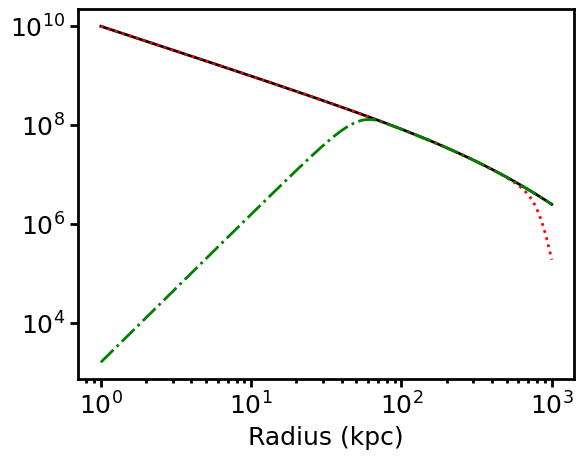

In [12]:
# - plot the original - #
fig,ax = plt.subplots(1,1)
profile_example.plot(1,1000,1000,fig=fig,ax=ax,color="k",ls="-")

# - truncate the profile - #
t_profile = profile_example.cutoff(800)
t_profile.plot(1,1000,1000,fig=fig,ax=ax,color="red",ls=":")

# - add a core - #
c_profile = profile_example.add_core(50,4)
c_profile.plot(1,1000,1000,fig=fig,ax=ax,color="green",ls="-.")

plt.show()

#### Creating Profiles

Okay, so we've seen how to play around with the existing profiles, but what if I want to use my own profile? How do I make it a ``RadialProfile`` object? 

There are two methods by which you can do this depending on what you already have. If you already have a ``callable`` object (function, lambda function, etc.) then you can simply call the class with the function as the argument. If you have raw data, you should use the ``.from_array`` method. Below is an example of each:

RadialProfile; type=sine. RadialProfile; type=cosine.


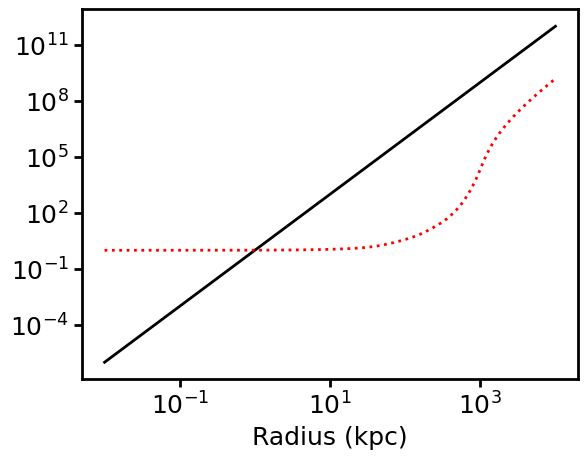

In [23]:
# -- Creating a profile with a function -- #
profile_1 = cg.radial_profiles.RadialProfile(lambda x: x**3,name="sine")

# -- creating a profile from data -- #
x = np.geomspace(1,1000,1000)
y = (x/100)**2 + np.exp(x/100)

profile_2 = cg.radial_profiles.RadialProfile.from_array(x,y,name="cosine")

print(profile_1,profile_2)

fig,ax = plt.subplots(1,1)
profile_1.plot(0.01,10000,1000,fig=fig,ax=ax,color="k",ls="-")
profile_2.plot(0.01,10000,1000,fig=fig,ax=ax,color="red",ls=":")

plt.show()

#### I/O Operations on RadialProfiles

The last interesting feature of ``RadialProfiles`` to discuss is that they can be saved to disk. This is generally of very little use; a function is usually rooted in an expression in code elsewhere and doesn't need to be written to disk. Nonetheless, ``cluster_generator`` allows for this because it is needed internally to facilitate some operations on other datatypes. To save a ``RadialProfile`` to disk, use ``.to_binary`` and read using ``.from_binary``. This operation serializes the ``RadialProfile`` object and allows it to be stored arbitrarily.

---



### Potentials
Now that we've seen ``RadialProfiles`` in there full glory, its time to start discussing the foundations of real systems. In ``cluster_generator``, the gravitational aspects of system are all handled by the ``Potential`` class, which is inherited by ``ClusterModel`` objects which will be covered later. Generally, there's no use in generating a ``Potential`` on its own; the ``ClusterModel`` class is much for useful on the user-side; however, it is worth understanding some of the core operations that occur at this level.

A ``Potential`` object  is essentially a fancy ``dict`` for holding data with a few additional parameters tacked on. The data is held in the ``.fields`` attribute, while other attributes are held in the ``.attrs`` attribute. The most important attribute of a ``Potential`` object is the ``.gravity`` attribute, which selects which Poisson solver to use under the hood. Let's check out how this works.

In [26]:
from cluster_generator.gravity import Potential

x = np.linspace(0,1,1000)
y = np.cos(x)

potential = Potential({"radius":x,"y":y},gravity="AQUAL",name="some name")

print(potential)

cluster_generator : [WARNING  ] 2023-08-23 18:42:16,986 Gravity AQUAL requires kwarg `interp_function`. Setting to default...
cluster_generator : [WARNING  ] 2023-08-23 18:42:16,990 Gravity AQUAL requires kwarg `a_0`. Setting to default...


Potential object; gravity=AQUAL, fields=['radius', 'y', 'gravitational_potential']


Okay, so we've got our ``potential`` object initialized in AQUAL gravity with 2 fields: ``radius`` and ``y``. You'll notice an additional field has been generated: ``gravitational_potential``. Let's try calling it:

In [27]:
print(potential["gravitational_potential"])

None


Its a ``None`` type, indicating that we haven't asked the ``Potential`` to actually solve for the potential yet. To do so, we have two options. We can either access the variable ``.pot``, which will auto generate the potential, or we can call ``.potential()``. Let's try the first one.

In [28]:
_ = potential.pot

cluster_generator : [INFO     ] 2023-08-23 18:44:54,278 Computing gravitational potential of Potential object; gravity=AQUAL. gravity=AQUAL.


ValueError: Failed to compute a potential from available fields. Message = ValueError("The self.fields ['radius', 'y', 'gravitational_potential'] are not sufficient for a potential computation.")

Oh no! What happened? In order for the ``Potential`` instance to actually compute the potential, it needs to have the necessary fields to carry out the computation using at least 1 method. To see more on the possible methods, look at the API documentation. Let's try again and give it the total mass, total density, and radius from which it can compute the potential:

In [30]:
# -- Create the profiles -- #
from unyt import unyt_array
z = 0.1
M200 = 1.5e15
conc = 4.0
r200 = cg.radial_profiles.find_overdensity_radius(M200, 200.0, z=z)
a = r200 / conc
M = cg.radial_profiles.snfw_total_mass(M200, r200, a)
rhot = cg.radial_profiles.snfw_density_profile(M, a)
m = cg.radial_profiles.snfw_mass_profile(M,a)
rmin,rmax = 0.1,2*r200
r =  np.geomspace(rmin,rmax,1000)
m,d,r = unyt_array(m(r),"Msun"),unyt_array(rhot(r),"Msun/kpc**3"),unyt_array(r,"kpc")

# -- creating the potential -- #
potential = Potential({"total_mass":m,"radius":r,"total_density":d},gravity="Newtonian")
_ = potential.pot

print(potential)

cluster_generator : [INFO     ] 2023-08-23 18:49:30,038 Computing gravitational potential of Potential object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-08-23 18:49:30,041 Computation of potential is using mdr for computation.


Potential object; gravity=Newtonian, fields=['total_mass', 'radius', 'total_density', 'gravitational_potential']


This time, we see that the computation has succeeded and we should have access to the gravitational potential:

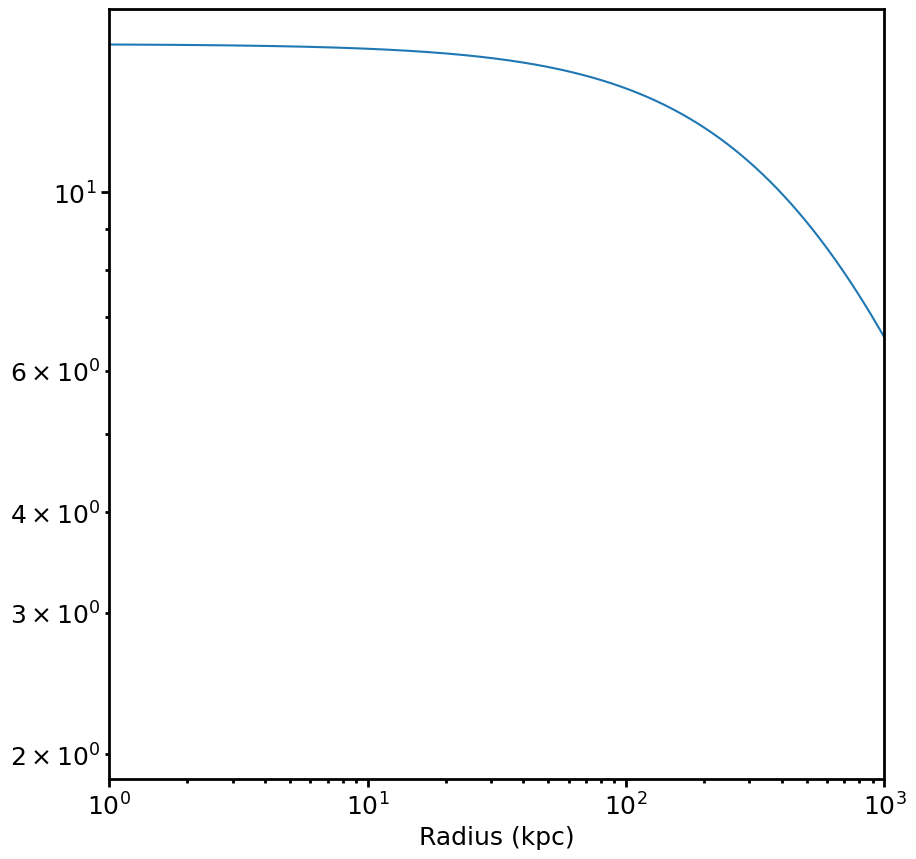

In [31]:
potential.plot(1,1000)
plt.show()

#### Alternative Gravity Theories

``cluster_generator`` allows users to implement not just Newtonian gravity, but MONDian gravity as well. To do so, change the ``gravity`` attribute in the initialization:

cluster_generator : [WARNING  ] 2023-08-23 18:54:23,839 Gravity QUMOND requires kwarg `interp_function`. Setting to default...
cluster_generator : [WARNING  ] 2023-08-23 18:54:23,841 Gravity QUMOND requires kwarg `a_0`. Setting to default...
cluster_generator : [INFO     ] 2023-08-23 18:54:23,843 Computing gravitational potential of Potential object; gravity=QUMOND. gravity=QUMOND.
cluster_generator : [INFO     ] 2023-08-23 18:54:23,845 Computation of potential is using mdr for computation.


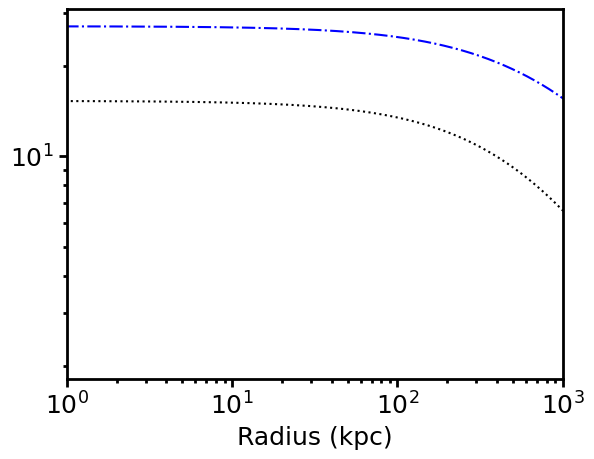

In [33]:
potential_qumond = Potential({"total_mass":m,"radius":r,"total_density":d},gravity="QUMOND")
_ = potential_qumond.pot

fig,ax = plt.subplots(1,1)
potential.plot(1,1000,fig=fig,ax=ax[0],color="black",ls=":")
potential_qumond.plot(1,1000,fig=fig,ax=ax[0],color="blue",ls="-.")

plt.show()


For more information on implementing MOND gravity in your models, see the corresponding guide.


### ClusterModel

### ClusterParticles

### ClusterICs